# A PyTorch workflow ( one of many )

1. Get data ready (turn into tensors)
2. Build or pick a pretrained model (to suit your problem)

*   2.1 : Pick a loss function and optimizer
*   2.2 : Build a training loop
3. Fit the model (training) to the data and make a prediction
4.Evaluate the model (inference)
5. Improve through experimentation
6. Save and reload your trained model



In [131]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# check pytorch version
torch.__version__

'2.6.0+cu124'

nn contains all of PyTorch's building blocks for neural networks


# 1. Data (preparing and loading)

Data can be almost anything in machine learning

* Excel spreadsheet
* Images of any kind
* Videos
* Text

Machine learning is a game of two parts:
1. Get data into a numerical representation
2. Build a model to learn patterns in that numerical representation


## To showcase this , lets create some *known* data using the linear regression formula

The formula for a simple linear regression is **Y = a + bX**, where:

Y: is the dependent variable (the variable you are trying to predict)

X: is the independent variable (the variable used to predict Y)

a: is the y-intercept (the value of Y when X is 0)

b: is the slope of the line (the change in Y for every one unit change in X)


In simpler terms, this formula represents a straight line that best fits the relationship between your data points. By plugging in values for X, you can predict the corresponding value of Y.

We will use a linear regression formula to make a straight line with *known* **parameters**

A **parameter** is something that a model learns

## Unsqueeze method:

**unsqueeze()** adds a new dimension, and the dim you give decides where that new axis goes in the shape. But it’s not exactly about "row vs column" - it's more like position in the tensor shape.

Let’s say you got this:


    x = torch.tensor([1, 2, 3])
 *shape: [3]*

Now:

x.unsqueeze(0) ➤ shape becomes [1, 3] → new dim added at the front. Think of it like batch size of 1, like

      [[1, 2, 3]]

x.unsqueeze(1) ➤ shape becomes [3, 1] → new dim added after the first → it’s now a column vector:

    [[1],
     [2],
     [3]]


So :

dim=0 → adds new axis before all existing dims

dim=1 → adds it after the first one

In [132]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# we know these numbers but we want to build a model that estimates these numbers

# Create a range of numbers
start = 0
end = 1
step = 0.02
# X is capital bcs a tensor or a matrix is represented with a uppercase letter
X = torch.arange(start , end , step).unsqueeze(dim = 1)
y = weight * X + bias

# X[:10] gives first ten values of X
X[:10] , y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [133]:
len(X) , len(y)

(50, 50)

So whar we're going to be doing is building a model to learn some values ,

to look at the X values here and learn what associated Y value is and the relationship between those

OFC , we know the relationship between X and Y here , because we have coded this formula

 `Y = weight * X + bias`
but you wont always know that

That is the whole premise of machine learning : to learn a representation of the input and how it maps to the output

# Splitting our data into training and test sets (most important concept in ML)

**Generalization** : The ability for a machine learning model to perform well on data it hasnt seen before

## Three datasets in ML:
In Machine Learning (ML), the three primary datasets are the **training set, validation set, and test set**. The training set is used to train the ML model. The validation set is used to tune the model's hyperparameters and prevent overfitting. The test set provides an unbiased evaluation of the final model's performance on unseen data.

**Training Set:**

This is the largest portion (60-80%) of the dataset, used to train the model. The model learns patterns and relationships from this data.
eg: The course materials you study during semester

**Validation Set:**

This set is used to evaluate the model's performance during training. It helps in selecting the best model configuration (e.g., choosing the right number of layers in a neural network or the best learning rate).

Amount of total data : (10-20%)

eg: The practice exam you take before the final exam


**Test Set:**

This set is kept separate from the training and validation sets. It is used to assess the model's generalization ability, meaning how well it performs on new, unseen data. This provides an unbiased evaluation of the model's performance.

Amount of total data : (10-20%)


eg: The final exam you take at end of semester



- You dont always need a validation set but training and testing  sets are important

###  create a training and testing set with our data

In [134]:
# 80-20 split is common
# 80% of X : training
train_split = int(0.8 * len(X))

# X: training data , y:training labels
X_train , y_train = X[:train_split] , y[:train_split]

# train_split: -> train_split onwards is the testing
X_test , y_test = X[train_split:] , y[train_split:]

# len(X) , len(y) ,len(X_train) , len(y_train) , len(X_test) , len(y_test)
print(f"Total data : ({len(X)})")
print(f"Training data : ({len(X_train)})")
print(f"Testing data : ({len(X_test)})")

Total data : (50)
Training data : (40)
Testing data : (10)


The total data for X , y -> was 50 each

we split the data into training and testing sets ,


80% of total (50) = 40  is for training


and rest 20% = 10 is for testing  

## How might we better visualize our data

Right now its just numbers on a page , that does not help much in visualizing

In [135]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):

    """
    Plots training data , test data and compares predictions
    """
    plt.figure(figsize=(10,7))

    # Plot training data in blue
    plt.scatter(train_data , train_labels , c="b" , s=4 , label = "Training data")

    # Plot testing data in green
    plt.scatter(test_data , test_labels , c="g" , s = 4 , label = "Testing data")

    # Are their any predictions?
    if predictions is not None:
      # plot the predictions
      plt.scatter(test_data , predictions , c="r" , s=4 , label="Predictions")

    # Show the legend
    plt.legend(prop={"size" : 14});

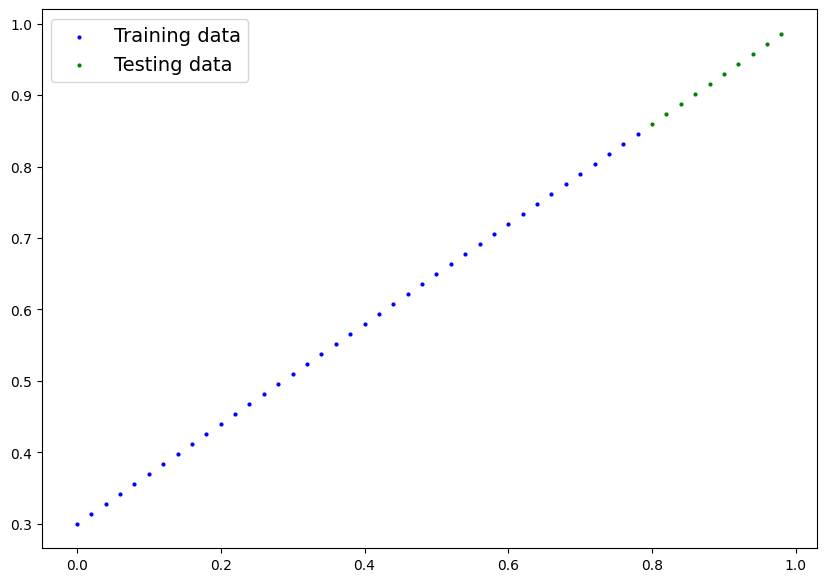

In [136]:
plot_predictions();
# This is blue in start and turns green towards the end

#  2. Build model - First Pytorch model

**What our model does?**
* Start with random values (weights , bias)
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values ( the weights and bias values we used to create the data )

How does it do so?

* Through two main algorithms -
    1. Gradient descent - ( why we have `requires_grad = True` )
    2. Backpropagation

    When we run computations using this model , pytorch is going to keep track of the gradients of our weights parameter and our bias parameter . And then its going to update them through a combination of gradient descent and back propagation

    PyTorch already has code written for these two algorithms

 Create linear regression model class:

- **nn.module** : Base class for all neural network modules.

   Your models should also subclass this class.

   Modules can also contain other Modules, allowing them to be nested in a tree structure

- **Tensor.requires_grad**:

   Is True if gradients need to be computed for this Tensor, False otherwise.

   Its true default.



In [137]:
# class inherits from nn.module -> almost everything in pytorch inherits from nn.module
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    # Initialise model parameters
    self.weights = nn.Parameter(torch.randn(1 ,
                                            requires_grad = True,
                                            dtype = torch.float))
    self.bias = nn.Parameter(torch.randn(1 ,
                                         requires_grad = True,
                                         dtype = torch.float))

    # Forward method to define the computation in the model , x is the input
  def forward(self ,x: torch.Tensor) -> torch.tensor:
    return self.weights * x + self.bias



### Code breakdown :

- `torch.randn(1 , ` -> Start with a random weight / bias value

- `requires_grad = True,` Can this parameter (weight / bias) be updated via gradient descent?
                  

### PyTorch model building essentials

- **torch.nn** - Contains all of the building blocks for computational graphs ( neural networks can be considered as computational graphs )

- **torch.nn.Parameter** - What parameters should our model try and learn , often a PyTorch layer from torch.nn will set these for us

- **torch.nn.Module** - The base class for all neural network modules , if you subclass it , you should overwrite forward()

- **torch.optim** - This is where optimizers in PyTorch live , they will help with gradient descent

- **def forward()** -  All nn.Module subclasses require you to overwirte forward() , this method defines what happens in the forward pass / computation

- **torch.utils.data.Dataset** - represents a map between key(label) and sample(features) pairs of your data. Such as images and their associated labels

- **torch.utils.data.DataLoader** - Creates a Python iterable over a torch Dataset (allows you to iterate over your data )

## Checking the contents of our PyTorch model

We have already created a model , lets see whats inside

So , we can check our model parameters or whats inside our model using .parameters()

In [138]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check the model parameters
list(model_0.parameters())


[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

**model.state_dict()** gives named parameters

In [139]:
# list named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

Here we have random values of weight and bias , these are the weights and bias in the LinearRegressionModel class

We also have known values (parameters) weights and bias with values = 0.7 and 0.3 above


Now , our whole goal is to write code that is going to allow our model to look at the blue dots in the graph and adjust this weight and bias value (of the model) to be as close as possible to the known values of weight and bias

The closer we get these values of these two , the better we're going to be able to predict and model our data

Now , this principle is the fundamental
entire foundation of deep learning

We start at random values , use gradient descent and backpropagation and whatever data that we're working with to move these random values as close as possible to ideal values. In most cases , you wont know what the ideal values are.

But right now our case is a simple one so we know

In [140]:
weight , bias

(0.7, 0.3)

## Make predictions using `torch.inference_mode()`

Inference mode is one of several mechanisms that can enable or disable gradients locally

example : we can also do:
        
      y_preds = model_0(X_test)

      y_preds

but that will track gradients , which we dont want right now.
So we use inference mode

You can also use `torch.no_grad()` for the same purpose , but inference mode has some pros over that

To check our model's predictive power , lets see how well it predicts `y_test` based on `X_test`

When we pass data through our model , its going to run it through the `forward()` method

Our ideal model will predict the exact values of Y test

In [141]:
X_test

tensor([[0.8000],
        [0.8200],
        [0.8400],
        [0.8600],
        [0.8800],
        [0.9000],
        [0.9200],
        [0.9400],
        [0.9600],
        [0.9800]])

In [142]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

In [143]:
# Make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

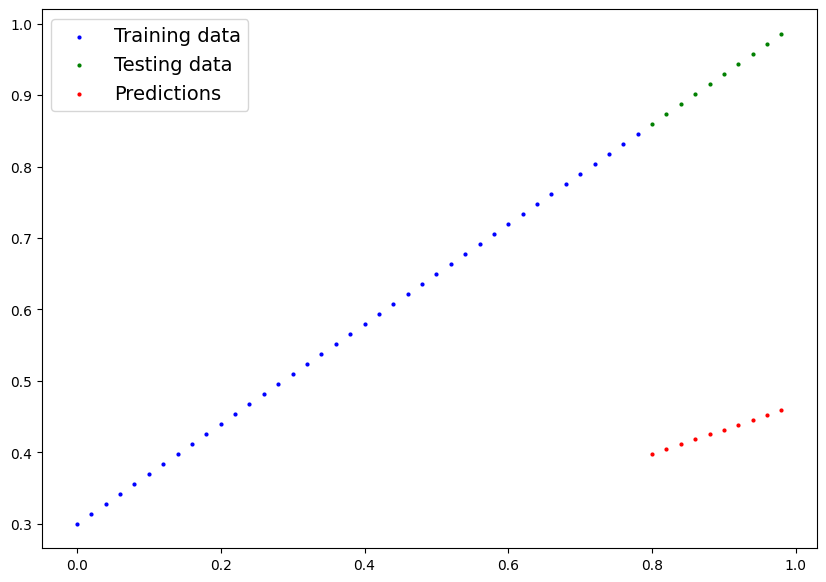

In [144]:
plot_predictions(predictions = y_preds)

Ideally , the red lines should be on top of the green dots

The predictions right now are extremely far

# 3. Training the model

The whole idea of training is for a model to move from some *unknown* parameters (these may be random) to some *known* parameters

Or in other words, from a poor representation of the data to a better representation of the data

One way to measure how poor or *how wrong your model's predictions are* is to use a **loss function**

* Note : Loss function may also be called cost function or criterion in different areas

* **Loss Function:** A loss function is a crucial part of machine learning models, quantifying the difference between predicted and actual values to guide the model's learning process. It essentially measures how well a model is performing, with lower loss indicating better performance. During training, algorithms like Gradient Descent use the loss function to adjust model parameters and minimize errors.


* **Optimizers:** Takes into account the loss of a model and adjusts the model's
parameters (Weights and bias) to improve loss function


And specifically in PyTorch we need:
- A training loop
- A testing loop

## Setting up loss function and optimizer with Pytorch

In [145]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

**Loss functions**:

- nn.L1loss : Creates a criterion that measures the mean absolute error (MAE) between each element in the input x and target y

      MAE_LOSS = torch.mean(torch.abs(y_pred - y_test)

      or

      torch.nn.L1Loss
- nn.MSEloss : Creates a criterion that measures the mean squared error (MSE) between each element in the input x and target y

- nn.CrossEntropyLoss: This criterion computes the cross energy loss between input and target. Used in classification models

**Optimizers:**
- SGD : Implements stochastic gradient descent (optionally with momentum).
- Adagrad : Implements Adagrad algorithm.
- Adam : Implements Adam algorithm.
- RMSprop : Implements RMSprop algorithm.

In [146]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer
optimizer = torch.optim.SGD(params = model_0.parameters() ,
                            lr = 0.01)


**LR:** learning rate is a crucial hyperparameter that determines the step size at which a model's parameters (weights) are updated during training. It essentially controls how quickly or slowly the model learns from the training data. A well-tuned learning rate is essential for efficient and effective training, as it balances the speed of convergence with the risk of overshooting the optimal solution

Learning rates in machine learning typically range from **0.0 to 1.0**, though values outside this range are sometimes used depending on the specific task and model. Common values often used as starting points include **0.1, 0.01, and 0.001.**

In machine learning, **hyperparameters** are settings that are configured before the learning process begins and control how the model learns from the data. They are not learned from the data itself, unlike model parameters, which are adjusted during training. Hyperparameters determine the model's architecture, learning rate, and other crucial aspects that significantly impact performance. Effective hyperparameter tuning is essential for achieving optimal model accuracy and generalization ability.


**Q** Which loss function and optimizer should i use?

**A.** This will be problem specific. But with experience , you will get an idea of what works and what doesnt with your particular problem set

For example: for a linear regression problem like ours , a loss function of `nn.L1Loss()` and an optimizer like `torch.optim.SGD()` will suffice.

But for a classification problem , you will likely use a loss function of `nn.BCELoss()` (binary cross entropy loss)

In [147]:
loss_fn , optimizer

(L1Loss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

## Building a training loop and a testing loop

A couple of things we need in a training loop:
0. Loop through the data
1. Forward pass (this involves data moving through our model's `forward()` functions) - also called **forward propagation**
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward **(backpropagation)**- move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss
5. Optimizer step **(gradient descent)** - use the optimizer to adjust our model's parameters to try and improve the loss

The unofficial PyTorch optimization loop song

It's train time!

Do the forward pass,

Calculate the loss,

Optimizer zero grad,

Losssss backward!

Optimizer step, step, step!

Testing Loop:

Let's test now!

With torch.no_grad():

Do the forward pass,

Calculate the loss,

Watch it go down, down, down!

In [148]:
# An epoch is one full loop through the data (this is a hyperparameter)
torch.manual_seed(42)
epochs = 1

for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that requires grad
                  # to require grad

  # forward pass:
  y_pred = model_0(X_train)

  # Calculate loss: order is imp here , (input first , target next)
  loss = loss_fn(y_pred , y_train)
  print(f"Loss: {loss}")

  # Optimizer zero grad
  optimizer.zero_grad()

  # Backpropagation wrt parameters
  loss.backward()

  # optimizer - perform gradient descent
  optimizer.step()
    #  by deafult how the optimizer changes will accumulate through the loop so
    # we have to zero them before in step 3


  model_0.eval()  # turns off grad tracking or different settings in model that
                  # are not neded for evaluation / testing

  print(model_0.state_dict())

Loss: 0.31288138031959534
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])


As i keep re-running the above code , i see the loss is going down every time and the values are coming closer to the known values , this is **gradient descent** happening

- Lower loss value is good

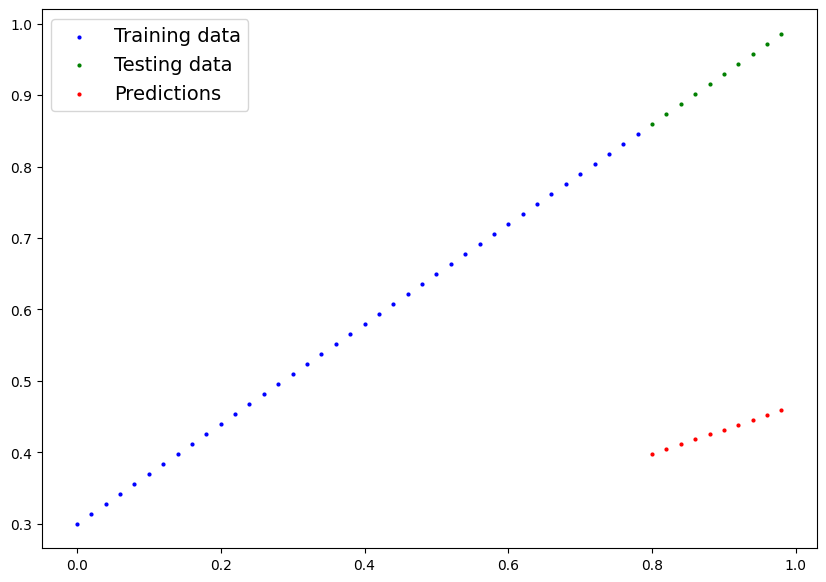

In [149]:
# earlier predictions:
plot_predictions(predictions = y_preds);

In [150]:
# current predictions
with torch.inference_mode():
  y_preds_new = model_0(X_test)

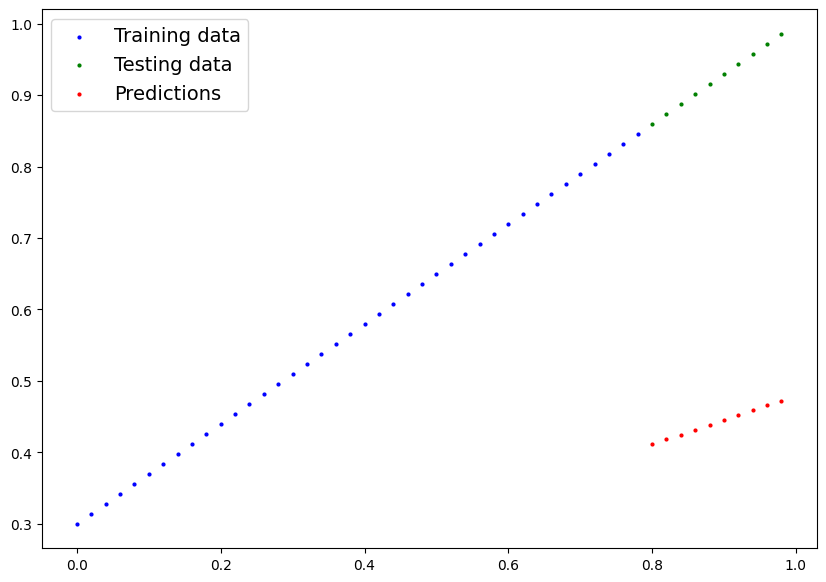

In [151]:
plot_predictions(predictions = y_preds_new)

Instead of re-running the code multiple times , we can make our epochs more and see

In [152]:
# # An epoch is one full loop through the data (this is a hyperparameter)
# torch.manual_seed(42)
# epochs = 150

# for epoch in range(epochs):
#   # Set the model to training mode
#   model_0.train() # train mode in PyTorch sets all parameters that requires grad
#                   # to require grad

#   # forward pass:
#   y_pred = model_0(X_train)

#   # Calculate loss: order is imp here , (input first , target next)
#   loss = loss_fn(y_pred , y_train)
#   print(f"Loss: {loss}")

#   # Optimizer zero grad
#   optimizer.zero_grad()

#   # Backpropagation wrt parameters
#   loss.backward()

#   # optimizer - perform gradient descent
#   optimizer.step()
#     #  by deafult how the optimizer changes will accumulate through the loop so
#     # we have to zero them before in step 3


#   model_0.eval()  # turns off grad tracking

#   print(model_0.state_dict())

In [153]:
# with torch.inference_mode():
#   y_preds_final = model_0(X_test)

In [154]:
# plot_predictions(predictions = y_preds_final)

Thats pretty close , we trained our first ML model and it did pretty good

Now it should also perform good on unseen data - that is testing the model

# Writing testing loop code

**Backpropagation** is a fundamental algorithm used to train artificial neural networks. It works by calculating the error at the output layer and then propagating it backward through the network to adjust the weights and biases of each layer, ultimately minimizing the overall error and improving the network's performance.

In [155]:
torch.manual_seed(42)
# An epoch is one full loop through the data (this is a hyperparameter)

epochs = 200

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that requires grad
                  # to require grad

  # forward pass:
  y_pred = model_0(X_train)

  # Calculate loss: order is imp here , (input first , target next)
  loss = loss_fn(y_pred , y_train)


  # Optimizer zero grad
  optimizer.zero_grad()

  # Backpropagation wrt parameters
  loss.backward()

  # optimizer - perform gradient descent
  optimizer.step()
    #  by deafult how the optimizer changes will accumulate through the loop so
    # we have to zero them before in step 3


  model_0.eval()  # turns off grad tracking or different settings in model that
                  # are not neded for evaluation / testing

  with torch.inference_mode():
    # 1.forward pass:
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred , y_test)
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch : {epoch} | loss : {loss} | Test loss : {test_loss}")
    print(model_0.state_dict())

Epoch : 0 | loss : 0.3013603389263153 | Test loss : 0.4675942063331604
OrderedDict([('weights', tensor([0.3445])), ('bias', tensor([0.1488]))])
Epoch : 10 | loss : 0.18615034222602844 | Test loss : 0.3328842222690582
OrderedDict([('weights', tensor([0.3835])), ('bias', tensor([0.2488]))])
Epoch : 20 | loss : 0.08227583020925522 | Test loss : 0.2069590985774994
OrderedDict([('weights', tensor([0.4222])), ('bias', tensor([0.3403]))])
Epoch : 30 | loss : 0.05181945487856865 | Test loss : 0.14023718237876892
OrderedDict([('weights', tensor([0.4539])), ('bias', tensor([0.3788]))])
Epoch : 40 | loss : 0.04503796249628067 | Test loss : 0.11182951927185059
OrderedDict([('weights', tensor([0.4768])), ('bias', tensor([0.3868]))])
Epoch : 50 | loss : 0.04132963344454765 | Test loss : 0.09809747338294983
OrderedDict([('weights', tensor([0.4956])), ('bias', tensor([0.3838]))])
Epoch : 60 | loss : 0.03785243630409241 | Test loss : 0.08776430785655975
OrderedDict([('weights', tensor([0.5134])), ('bia

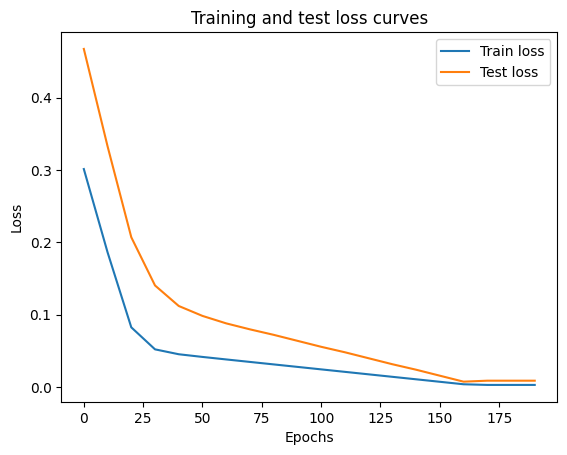

In [162]:
# Plot the loss curves
import numpy as np
plt.plot(epoch_count , np.array(torch.tensor(loss_values).numpy()) , label='Train loss')
plt.plot(epoch_count , test_loss_values , label='Test loss')
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();


Look at this graph , of they match up closely at some point , that means our model is converging and the loss is getting as close to 0 as it possibly can

In [158]:
with torch.inference_mode():
  y_preds_final = model_0(X_test)

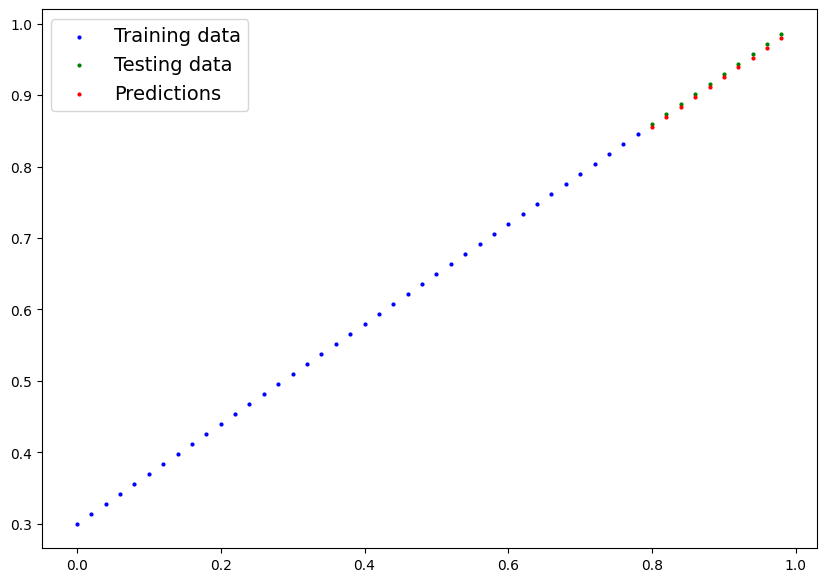

In [159]:
plot_predictions(predictions = y_preds_final)

## Saving a model in PyTorch

there are three main methods you should know about for saving and loading models in pytorch

1. `torch.save()` - allows you to save a PyTorch object in Python's pickle format

-
The pickle module implements binary protocols for serializing and de-serializing a Python object structure. “Pickling” is the process whereby a Python object hierarchy is converted into a byte stream, and “unpickling” is the inverse operation, whereby a byte stream (from a binary file or bytes-like object) is converted back into an object hierarchy.

2. `torch.load()` - allows you to load a saved PyTorch object

3. `torch.nn.Module.load_state_dict()` - allows you to load a model's saved state dictionary

In [163]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6951])), ('bias', tensor([0.2993]))])

If we save this from within Google Colab , the model will disappear if our Google Colab notebook instance disconnects

Google Colab also has a way to save from Google Colab to Google Drive :

1. Open your Colab notebook:
Start by opening the Colab notebook you want to save.
2. Save a copy to Drive:
Go to File > Save a copy in Drive. This creates a duplicate of your notebook in your Google Drive.
3. Locate the saved notebook:
The copied notebook will be stored in your Google Drive, specifically within the "Colab Notebooks" folder.
4. Save the current state:
You can also save the current version of your notebook at any time by going to File > Save. This saves the current state of the notebook to your Google Drive.
5. Accessing from Google Drive:

In [165]:
# Saving our PyTorch model
from pathlib import Path
# 1. Create models directory
# this is going to help us create a folder in files called "models" or we can
# make it by hand
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True , exist_ok = True)

# 2. Create model save path: This way we can give our model a name
# Right now its just model_0
MODEL_NAME = "3_pytorch_workfolow_linearRegression_model0.pth"
# pytorch objects usually have the extension .pth or .pt
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME


# 3. Save the model - using state dict is recommended
print(f"Saving model to : {MODEL_SAVE_PATH}")
# f: PathLike object containing a file name
torch.save(obj = model_0.state_dict() , f = MODEL_SAVE_PATH)

Saving model to : models/3_pytorch_workfolow_linearRegression_model0.pth


In [166]:
!ls -1 models

3_pytorch_workfolow_linearRegression_model0.pth


## Loading a PyTorch model

Since we saved our model's `state_dict()` rather than the entire model , we will create a new instance of our model class
and load the saved `state_dict()` into that

In [167]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6951])), ('bias', tensor([0.2993]))])

In [168]:
# To load in a saved state_dict we have to instantiate a new instance of
# our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0 (this will update the new instane
# with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [170]:
#   It will now have save values as model_0.state_dict()
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6951])), ('bias', tensor([0.2993]))])

In [172]:
# Make some predictions with our loaded model
# when we make predictions we gotta use eval mode and inference mode
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds= loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8554],
        [0.8693],
        [0.8832],
        [0.8971],
        [0.9110],
        [0.9249],
        [0.9388],
        [0.9527],
        [0.9666],
        [0.9805]])

To see if these two models are the same , we can compare loaded_model_preds with original model_preds



In [174]:
model_0.eval()
with torch.inference_mode():
  y_preds = model_0(X_test)
y_preds

tensor([[0.8554],
        [0.8693],
        [0.8832],
        [0.8971],
        [0.9110],
        [0.9249],
        [0.9388],
        [0.9527],
        [0.9666],
        [0.9805]])

In [175]:
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])